In [171]:
import os, fnmatch, glob
import numpy as np
import pandas as pd
from sklearn.cluster import MeanShift, estimate_bandwidth
from astropy.io import fits
from io import StringIO

from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
import astropy.units as u

# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.4/dist-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## We define the folder that contain the FITS images and Night log files

In [227]:
survey_file = 'data/MS_VISTA_P98.csv'
im_folder= '/mnt/data2/ESO/raw'
im_pattern = '*.fits.fz'

log_folder= '/mnt/data2/ESO/raw'
log_pattern = '*.NL.txt'

header_keys = ['DATE-OBS', 'RA', 'DEC', \
    'HIERARCH ESO OBS PROG ID', 'HIERARCH ESO OBS NAME', 'HIERARCH ESO DPR TYPE', \
    'HIERARCH ESO INS FILT1 NAME', 'HIERARCH ESO DET DIT', 'HIERARCH ESO DET NDIT', \
    'HIERARCH ESO TPL ID', 'HIERARCH ESO TPL NEXP', 'HIERARCH ESO TPL EXPNO', \
    'OFFST_ID','NOFFSETS', 'OFFSET_I', \
    'JITTR_ID','NJITTER', 'JITTER_I']

survey_info= pd.DataFrame([{'Tile':1, 'RA':'23:26:07.46', 'Dec':'-53:28:13.7'}, \
              {'Tile':2, 'RA':'23:53:46.15', 'Dec':'-52:32:21.7'}, \
              {'Tile':3, 'RA':'00:22:34.67', 'Dec':'-51:17:37.6'}, \
              {'Tile':4, 'RA':'00:53:43.00', 'Dec':'-49:36:27.2'}, \
              {'Tile':5, 'RA':'01:03:22.85', 'Dec':'-48:35:37.4'}, \
              {'Tile':6, 'RA':'01:12:56.00', 'Dec':'-47:35:04.6'}], columns=['Tile', 'RA','Dec'])

In [204]:
im_files = glob.glob( os.path.join(im_folder,  im_pattern))
print("Number of images: ", len(im_files))

Number of images:  9207


In [205]:
log_files = glob.glob( os.path.join(log_folder,  log_pattern))
print("Number of log files: ", len(log_files))

Number of log files:  403


## Let's process the FITS headers

In [206]:
survey_list=[]
for i, im_file in enumerate(im_files):
    if i % 100 == 0:
        print('Processing file ', i, ' of ', len(im_files))
    hdulist = fits.open(im_file)
    im_header = hdulist[0].header
    result = {}
    for key in header_keys:
        if key in im_header:
            result[key] = im_header[key]
        else:
            result[key] = np.nan
    result['Filename'] = im_file
    survey_list.append(result)

survey_df = pd.DataFrame(survey_list, columns=['Filename']+header_keys)
survey_df['DATE-OBS']=pd.to_datetime(survey_df['DATE-OBS'])
survey_df.rename(columns={'DEC':'Dec'}, inplace=True)
survey_df.sort_values('DATE-OBS', inplace=True)

Processing file  0  of  9207
Processing file  100  of  9207
Processing file  200  of  9207
Processing file  300  of  9207
Processing file  400  of  9207
Processing file  500  of  9207
Processing file  600  of  9207
Processing file  700  of  9207
Processing file  800  of  9207
Processing file  900  of  9207
Processing file  1000  of  9207
Processing file  1100  of  9207
Processing file  1200  of  9207
Processing file  1300  of  9207
Processing file  1400  of  9207
Processing file  1500  of  9207
Processing file  1600  of  9207
Processing file  1700  of  9207
Processing file  1800  of  9207
Processing file  1900  of  9207
Processing file  2000  of  9207
Processing file  2100  of  9207
Processing file  2200  of  9207
Processing file  2300  of  9207
Processing file  2400  of  9207
Processing file  2500  of  9207
Processing file  2600  of  9207
Processing file  2700  of  9207
Processing file  2800  of  9207
Processing file  2900  of  9207
Processing file  3000  of  9207
Processing file  310

In [208]:
survey_df.head()

,Filename,DATE-OBS,RA,Dec,HIERARCH ESO OBS PROG ID,HIERARCH ESO OBS NAME,HIERARCH ESO DPR TYPE,HIERARCH ESO INS FILT1 NAME,HIERARCH ESO DET DIT,HIERARCH ESO DET NDIT,HIERARCH ESO TPL ID,HIERARCH ESO TPL NEXP,HIERARCH ESO TPL EXPNO,OFFST_ID,NOFFSETS,OFFSET_I,JITTR_ID,NJITTER,JITTER_I
1352,/mnt/data2/ESO/raw/VCAM.2016-09-08T22:51:04.20...,2016-09-08 22:51:04.199900,299.832942,-60.08321,60.A-9293(A),TwilightFlatsKs-5,"FLAT,TWILIGHT",Ks,3.0,1,VIRCAM_img_cal_twiflat,23,8,Offsets,16.0,1.0,NaN,NaN,NaN
6361,/mnt/data2/ESO/raw/VCAM.2016-09-08T22:51:21.23...,2016-09-08 22:51:21.219900,299.832517,-60.02746,60.A-9293(A),TwilightFlatsKs-5,"FLAT,TWILIGHT",Ks,3.0,1,VIRCAM_img_cal_twiflat,23,9,Offsets,16.0,2.0,NaN,NaN,NaN
2418,/mnt/data2/ESO/raw/VCAM.2016-09-08T22:51:39.76...,2016-09-08 22:51:39.746000,299.832521,-59.97191,60.A-9293(A),TwilightFlatsKs-5,"FLAT,TWILIGHT",Ks,3.0,1,VIRCAM_img_cal_twiflat,23,10,Offsets,16.0,3.0,NaN,NaN,NaN
6845,/mnt/data2/ESO/raw/VCAM.2016-09-08T22:51:55.76...,2016-09-08 22:51:55.765300,299.832542,-59.91636,60.A-9293(A),TwilightFlatsKs-5,"FLAT,TWILIGHT",Ks,3.0,1,VIRCAM_img_cal_twiflat,23,11,Offsets,16.0,4.0,NaN,NaN,NaN
7719,/mnt/data2/ESO/raw/VCAM.2016-09-08T22:52:16.21...,2016-09-08 22:52:16.211400,300.055267,-60.08366,60.A-9293(A),TwilightFlatsKs-5,"FLAT,TWILIGHT",Ks,3.0,1,VIRCAM_img_cal_twiflat,23,12,Offsets,16.0,5.0,NaN,NaN,NaN


In [209]:
survey_df['HIERARCH ESO DPR TYPE'].unique()

array(['FLAT,TWILIGHT', 'DARK', 'STD,FLUX', 'OBJECT', 'DARK,GAIN',
       'FLAT,LAMP,GAIN', 'DARK,LINEARITY', 'DARK,CHECK',
       'FLAT,LAMP,LINEARITY', 'FLAT,LAMP,CHECK'], dtype=object)

In [210]:
survey_science_df = survey_df[survey_df['HIERARCH ESO DPR TYPE']=='OBJECT'].copy()
survey_science_df.head()

,Filename,DATE-OBS,RA,Dec,HIERARCH ESO OBS PROG ID,HIERARCH ESO OBS NAME,HIERARCH ESO DPR TYPE,HIERARCH ESO INS FILT1 NAME,HIERARCH ESO DET DIT,HIERARCH ESO DET NDIT,HIERARCH ESO TPL ID,HIERARCH ESO TPL NEXP,HIERARCH ESO TPL EXPNO,OFFST_ID,NOFFSETS,OFFSET_I,JITTR_ID,NJITTER,JITTER_I
6250,/mnt/data2/ESO/raw/VCAM.2016-09-10T01:22:35.27...,2016-09-10 01:22:35.272000,351.377896,-53.28692,098.B-0510(A),MS_DV1_V5_OB61,OBJECT,Ks,7.0,4,VIRCAM_img_obs_tile6,18,1,Tile6n,6.0,1.0,Jitter3u,3.0,1.0
2074,/mnt/data2/ESO/raw/VCAM.2016-09-10T01:23:24.30...,2016-09-10 01:23:24.294000,351.373604,-53.28393,098.B-0510(A),MS_DV1_V5_OB61,OBJECT,Ks,7.0,4,VIRCAM_img_obs_tile6,18,2,Tile6n,6.0,1.0,Jitter3u,3.0,2.0
8334,/mnt/data2/ESO/raw/VCAM.2016-09-10T01:24:09.71...,2016-09-10 01:24:09.716300,351.382858,-53.28950,098.B-0510(A),MS_DV1_V5_OB61,OBJECT,Ks,7.0,4,VIRCAM_img_obs_tile6,18,3,Tile6n,6.0,1.0,Jitter3u,3.0,3.0
8633,/mnt/data2/ESO/raw/VCAM.2016-09-10T01:25:00.27...,2016-09-10 01:25:00.272200,351.531417,-53.28700,098.B-0510(A),MS_DV1_V5_OB61,OBJECT,Ks,7.0,4,VIRCAM_img_obs_tile6,18,4,Tile6n,6.0,2.0,Jitter3u,3.0,1.0
6756,/mnt/data2/ESO/raw/VCAM.2016-09-10T01:25:43.92...,2016-09-10 01:25:43.928400,351.526454,-53.28423,098.B-0510(A),MS_DV1_V5_OB61,OBJECT,Ks,7.0,4,VIRCAM_img_obs_tile6,18,5,Tile6n,6.0,2.0,Jitter3u,3.0,2.0


## Let's process the night log files

In [211]:
for i, log_file in enumerate(log_files):
    if i % 100 == 0:
        print('Processing log file ', i, ' of ', len(log_files))
    log_data=""
    log_data_append=False
    log_data_template=False
    with open(log_file) as f:
        for line in f:
            if line.startswith("Name:"):
                log_name=line.split(":")[1].strip()
            if line.startswith("Grade:"):
                log_grade=line.split(":")[1].strip()
            if line.startswith("Template:"):
                log_data_template=True
                
            if log_data_template==True and log_data_append==False:
                if line.startswith("-----"):
                    log_data_append=True
            elif log_data_template==True and log_data_append==True:
                if line.startswith("-----"):
                    og_data_template=False
                    log_data_append=False
                    break
                line = line.rstrip("\t\n")
                log_data = log_data + line.replace(" ","_").replace("\t",",") + "\n"
        
        log_data = StringIO(log_data)
        log_df = pd.read_csv(log_data)
        log_df['OBS.NAME'] = log_name
        log_df['ESOGRADE'] = log_grade
        
    if i==0:
        survey_log_df=log_df
    else:
        survey_log_df=survey_log_df.append(log_df, ignore_index=True)
                

Processing log file  0  of  403
Processing log file  100  of  403
Processing log file  200  of  403
Processing log file  300  of  403
Processing log file  400  of  403


In [212]:
survey_log_df.head()

,Original_Filename,Archive_Filename,TPL.EXPNO/NEXP,DPR.TYPE,INS.FILT1.NAME,EXPTIME,OBS.NAME,ESOGRADE
0,VIRCAM_IMG_OBS273_0227.fits,VCAM.2016-09-29T03:32:05.332,1/18,OBJECT,Ks,28.0,MS_DV3_V5_OB32,A
1,VIRCAM_IMG_OBS273_0228.fits,VCAM.2016-09-29T03:32:48.657,2/18,OBJECT,Ks,28.0,MS_DV3_V5_OB32,A
2,VIRCAM_IMG_OBS273_0229.fits,VCAM.2016-09-29T03:33:34.068,3/18,OBJECT,Ks,28.0,MS_DV3_V5_OB32,A
3,VIRCAM_IMG_OBS273_0230.fits,VCAM.2016-09-29T03:34:25.783,4/18,OBJECT,Ks,28.0,MS_DV3_V5_OB32,A
4,VIRCAM_IMG_OBS273_0231.fits,VCAM.2016-09-29T03:35:11.217,5/18,OBJECT,Ks,28.0,MS_DV3_V5_OB32,A


In [213]:
survey_log_df['ESOGRADE'].unique()

array(['A', 'B', 'C', '_'], dtype=object)

In [214]:
survey_log_df.columns

Index(['Original_Filename', 'Archive_Filename', 'TPL.EXPNO/NEXP', 'DPR.TYPE',
       'INS.FILT1.NAME', 'EXPTIME', 'OBS.NAME', 'ESOGRADE'],
      dtype='object')

In [215]:
survey_log_df.groupby(['ESOGRADE']).agg('count')

,Original_Filename,Archive_Filename,TPL.EXPNO/NEXP,DPR.TYPE,INS.FILT1.NAME,EXPTIME,OBS.NAME
ESOGRADE,,,,,,,
A,4248,4248,4248,4248,4248,4248,4248
B,1167,1167,1167,1167,1167,1167,1167
C,1719,1719,1719,1719,1719,1719,1719
_,5,5,5,5,5,5,5


## Counting the total number of images per tile

Adding columng 'Archive_Filename' to survey_science_df

In [216]:
survey_science_df.loc[:,'Archive_Filename']=survey_science_df['Filename'].apply(lambda x: os.path.basename(x).strip(".fits.fz"))

Merging survey_science_df and survey_log_df using column 'Archive_Filename'. The new dataframe is stored in survey_science_log

In [219]:
survey_science_log = survey_science_df.merge(survey_log_df[['Archive_Filename','OBS.NAME','ESOGRADE']], how='inner', on='Archive_Filename')
survey_science_log.head()

,Filename,DATE-OBS,RA,Dec,HIERARCH ESO OBS PROG ID,HIERARCH ESO OBS NAME,HIERARCH ESO DPR TYPE,HIERARCH ESO INS FILT1 NAME,HIERARCH ESO DET DIT,HIERARCH ESO DET NDIT,...,HIERARCH ESO TPL EXPNO,OFFST_ID,NOFFSETS,OFFSET_I,JITTR_ID,NJITTER,JITTER_I,Archive_Filename,OBS.NAME,ESOGRADE
0,/mnt/data2/ESO/raw/VCAM.2016-09-10T01:22:35.27...,2016-09-10 01:22:35.272000,351.377896,-53.28692,098.B-0510(A),MS_DV1_V5_OB61,OBJECT,Ks,7.0,4,...,1,Tile6n,6.0,1.0,Jitter3u,3.0,1.0,VCAM.2016-09-10T01:22:35.279,MS_DV1_V5_OB61,B
1,/mnt/data2/ESO/raw/VCAM.2016-09-10T01:23:24.30...,2016-09-10 01:23:24.294000,351.373604,-53.28393,098.B-0510(A),MS_DV1_V5_OB61,OBJECT,Ks,7.0,4,...,2,Tile6n,6.0,1.0,Jitter3u,3.0,2.0,VCAM.2016-09-10T01:23:24.301,MS_DV1_V5_OB61,B
2,/mnt/data2/ESO/raw/VCAM.2016-09-10T01:24:09.71...,2016-09-10 01:24:09.716300,351.382858,-53.28950,098.B-0510(A),MS_DV1_V5_OB61,OBJECT,Ks,7.0,4,...,3,Tile6n,6.0,1.0,Jitter3u,3.0,3.0,VCAM.2016-09-10T01:24:09.716,MS_DV1_V5_OB61,B
3,/mnt/data2/ESO/raw/VCAM.2016-09-10T01:25:00.27...,2016-09-10 01:25:00.272200,351.531417,-53.28700,098.B-0510(A),MS_DV1_V5_OB61,OBJECT,Ks,7.0,4,...,4,Tile6n,6.0,2.0,Jitter3u,3.0,1.0,VCAM.2016-09-10T01:25:00.279,MS_DV1_V5_OB61,B
4,/mnt/data2/ESO/raw/VCAM.2016-09-10T01:25:43.92...,2016-09-10 01:25:43.928400,351.526454,-53.28423,098.B-0510(A),MS_DV1_V5_OB61,OBJECT,Ks,7.0,4,...,5,Tile6n,6.0,2.0,Jitter3u,3.0,2.0,VCAM.2016-09-10T01:25:43.929,MS_DV1_V5_OB61,B


In [220]:
survey_science_log.groupby(['ESOGRADE','OFFSET_I']).agg('count')['Filename']

ESOGRADE  OFFSET_I
A         1.0         708
          2.0         708
          3.0         708
          4.0         708
          5.0         708
          6.0         708
B         1.0         198
          2.0         198
          3.0         195
          4.0         192
          5.0         192
          6.0         192
C         1.0         294
          2.0         289
          3.0         288
          4.0         284
          5.0         282
          6.0         282
_         1.0           5
Name: Filename, dtype: int64

We keep only OBs with ESOGRADE equals A or B

In [228]:
survey_science_log_good = survey_science_log[(survey_science_log['ESOGRADE']=='A') | (survey_science_log['ESOGRADE']=='B') ]

In [229]:
survey_info

,Tile,RA,Dec
0,1,23:26:07.46,-53:28:13.7
1,2,23:53:46.15,-52:32:21.7
2,3,00:22:34.67,-51:17:37.6
3,4,00:53:43.00,-49:36:27.2
4,5,01:03:22.85,-48:35:37.4
5,6,01:12:56.00,-47:35:04.6


In [230]:
def separation(x, tile_coo):
    c=SkyCoord(x['RA'], x['Dec'], unit=(u.deg, u.deg), frame='icrs')
    result=c.separation(tile_coo)
    return result.deg

for i in range(len(survey_info)):
    print('Analysing the images of Tile ', survey_info.loc[i,'Tile'])
    #survey_science_log_good
    print('RA: ', survey_info.loc[i,'RA'])
    print('Dec: ', survey_info.loc[i,'Dec'])

    tile_coo=SkyCoord(survey_info.loc[i,'RA'], survey_info.loc[i,'Dec'], unit=(u.hour, u.deg), frame='icrs')
    separation_df=survey_science_log_good.apply(separation, tile_coo=tile_coo, axis=1)
    print('Total number of images: ', len(survey_science_log_good[separation_df < 0.5]))
    print()

Analysing the images of Tile  1
RA:  23:26:07.46
Dec:  -53:28:13.7
Total number of images:  1098

Analysing the images of Tile  2
RA:  23:53:46.15
Dec:  -52:32:21.7
Total number of images:  1077

Analysing the images of Tile  3
RA:  00:22:34.67
Dec:  -51:17:37.6
Total number of images:  1080

Analysing the images of Tile  4
RA:  00:53:43.00
Dec:  -49:36:27.2
Total number of images:  1080

Analysing the images of Tile  5
RA:  01:03:22.85
Dec:  -48:35:37.4
Total number of images:  0

Analysing the images of Tile  6
RA:  01:12:56.00
Dec:  -47:35:04.6
Total number of images:  1080



## Display FITS images

In [8]:
im_data = hdulist[1].data
im_data.shape

(2048, 2048)

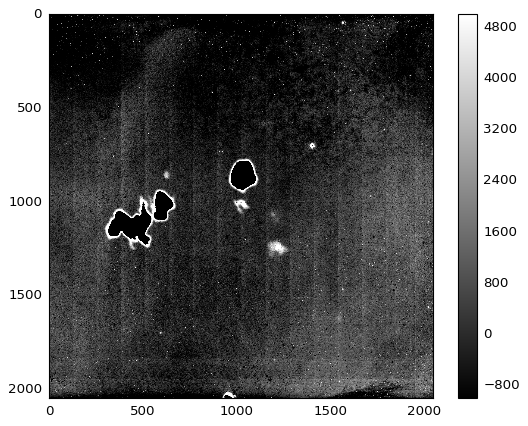

In [21]:
ss_data = im_data - np.median(im_data)

plt.imshow(ss_data, cmap='gray', vmin=-1e3, vmax=5e3)
plt.colorbar()